# Infer ***golgi*** - part 6️⃣

--------------
OBJECTIVE:  ✅ Infer sub-cellular component ***golgi complex***  in order to understand interactome 

Dependencies:
The ***golgi***  inference rely on the **cytosol** mask. 

## preamble

1. imports
2. setup
3. choose_Z
4. get soma mask
5. infer nuclei object  
6. get cytosol mask


## IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict
from typing import Optional

import numpy as np

from aicssegmentation.core.seg_dot import dot_2d_slice_by_slice_wrapper, dot_3d_wrapper
from aicssegmentation.core.utils import topology_preserving_thinning
from skimage.measure import label

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))


from infer_subc_2d.utils.file_io import (read_czi_image,
                                                                    read_ome_image,
                                                                    export_inferred_organelle,
                                                                    import_inferred_organelle,
                                                                    list_image_files)

from infer_subc_2d.utils.img import *

from infer_subc_2d.organelles import fixed_infer_soma_MCZ, fixed_infer_nuclei, infer_cytosol


%load_ext autoreload
%autoreload 2


In [2]:
# NOTE:  these "constants" are only accurate for the testing MCZ dataset
from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROXI_CH ,
                                                                    ER_CH ,
                                                                    LIPID_CH ,
                                                                    RESIDUAL_CH )              


## SETUP

In [3]:
# this will be the example image for testing the pipeline below
test_img_n = TEST_IMG_N

# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
in_data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

# save output ".tiff" files here
out_data_path = data_root_path / "out"

if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [4]:
img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## GET CYTOSOL MASK


In [5]:
# nuclei_fname = "/Users/ahenrie/Projects/Imaging/data/out/nuclei_ZSTACK_PBTOhNGN2hiPSCs_BR3_N04_Unmixed.ome.tiff"

cytosol_mask = import_inferred_organelle("cytosol", meta_dict, out_data_path)

if cytosol_mask is None:
    nuclei =  fixed_infer_nuclei(img_data) 
    soma = fixed_infer_soma_MCZ(img_data, nuclei)
    nucleus_obj =  apply_mask(nuclei, soma) 
    cytosol_mask =  infer_cytosol(soma, nucleus_obj, erode_nuclei=False) 
    out_file_n = export_inferred_organelle(cytosol_mask, "cytosol", meta_dict, out_data_path)
    print(f"calculated cytosol mask. wrote {out_file_n}")
else:
    print(f"loaded cytosol mask from {out_data_path}")


loaded cytosol mask from /Users/ahenrie/Projects/Imaging/data/out


---------------------

## infer ***golgi complex***

## summary of steps 
INPUT
- ch 4
- cytosol mask

PRE-PROCESSING
-   non-local noise reduction
  - size:4, distance:2, cut-off:0.1

CORE-PROCESSING
- adaptive Otsu
    - diameter: (4,100)
  - two classes
    - threshold smoothing scale: 1.34
    - threshold correction factor: .75
    - threshold bounds: (0.14, 1)
    - adaptive window: 20 pixels

  - adaptive Sauvola
    - threshold smoothing scale: 0
    - threshold correction factor: .6
    - threshold bounds: (0. ,1.0)
    - adaptive window: 20 pixels

- POST-PROCESSING
  - N/A

OUTPUT
- inferred  ***golgi*** object


Generally following the Allen Cell Segmenter procedure, but doing more aggressive contrast scaling than their prescribed contrast scaling.

> As per the Allen Cell segmenter sialyltransferase 1 (ST6GAL1) a potential Golgi segmenter. e.g. [Allen Cell](https://www.allencell.org/cell-observations/category/golgi-apparatus).    using [seg_st6gal1.py]("../../../../aics-segmentation/aicssegmentation/structure_wrapper/seg_st6gal1.py") and [playground_st6gal1.ipynb]("../../../../aics-segmentation/lookup_table_demo/playground_st6gal1.ipynb")


>#### ASIDE: Perform topology-preserving thinning 
>There are two parameters:
>* `thin_dist_preserve`: Half of the minimum width you want to keep from being thinned. For example, when the object width is smaller than 4, you don't want to make this part even thinning (may break the thin object and alter the topology), you can set `thin_dist_preserve` as `2`.
>* `thin_dist`: the amount to thin (has to be an positive integer). The number of pixels to be removed from outter boundary towards center


## INPUT prototype

In [6]:

###################
# INPUT
###################
raw_golgi = select_channel_from_raw(img_data, GOLGI_CH)



## PRE-PROCESSING prototype


In [17]:
###################
# PRE_PROCESSING
###################
median_sz = 4
gauss_sig = 1.34

struct_img =  scale_and_smooth(raw_golgi,
                                                    median_sz = median_sz, 
                                                    gauss_sig = gauss_sig)

## CORE PROCESSING prototype

In [18]:
###################
# CORE_PROCESSING
###################
################################
## PARAMETERS for this step ##
cell_wise_min_area = 1200
dot_2d_sigma = 1.6
dot_2d_cutoff = 0.02
thin_dist = 1
thin_dist_preserve = 1.6



###################
# CORE_PROCESSING
###################

bw, object_for_debug = MO(struct_img, 
                                                global_thresh_method='tri', 
                                                object_minArea=cell_wise_min_area, 
                                                return_object=True)


thin_dist_preserve = 1.6
thin_dist = 1
bw_thin = topology_preserving_thinning(bw, thin_dist_preserve, thin_dist)


################################
## PARAMETERS for this step ##
#s3_param = [[1.6, 0.02]]
s3_param = [(dot_2d_sigma,dot_2d_cutoff)]
################################

# bw_extra = dot_3d_wrapper(structure_img_smooth, s3_param)
bw_extra = dot_2d_slice_by_slice_wrapper(struct_img, s3_param)

bw_combine = np.logical_or(bw_extra, bw_thin)


## POST-PROCESSING prototype

In [19]:
###################
# POST_PROCESSING
###################
small_object_width = 3

golgi_object = size_filter_linear_size(bw_combine, 
                                                min_size= small_object_width, 
                                                connectivity=1)


#### Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [20]:
viewer = napari.Viewer()


In [21]:

viewer.add_image(
    golgi_object,
    scale=scale
)



<Image layer 'golgi_object' at 0x16083cca0>

In [22]:
viewer.scale_bar.visible = True
viewer.add_image(
    bw_extra,
    scale=scale
)
viewer.add_image(
    bw_thin,
    scale=scale
)


<Image layer 'bw_thin' at 0x16a2f38e0>

## DEFINE `infer_golgi` function

Based on the _prototyping_ above define the function to infer the golgi.  


In [23]:
##########################
#  infer_golgi
##########################
def _infer_golgi(
            in_img: np.ndarray,
            median_sz: int,
            gauss_sig: float,
            mo_method: str,
            mo_adjust: float,
            mo_cutoff_size: int,
            min_thickness: int,
            thin: int,
            dot_scale: float,
            dot_cut: float,
            small_obj_w: int,
        ) -> np.ndarray:

    """
    Procedure to infer golgi from linearly unmixed input.

   Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    median_sz: 
        width of median filter for signal
    mo_method: 
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    mo_adjust: 
        Masked Object threshold `local_adjust`
    mo_cutoff_size: 
        Masked Object threshold `size_min`
    min_thinkness: 
        Half of the minimum width you want to keep from being thinned.
        For example, when the object width is smaller than 4, you don't
        want to make this part even thinner (may break the thin object
        and alter the topology), you can set this value as 2.
    thin: 
        the amount to thin (has to be an positive integer). The number of
         pixels to be removed from outter boundary towards center.
    dot_scale: 
        scales (log_sigma) for dot filter (1,2, and 3)
    dot_cut: 
        threshold for dot filter thresholds (1,2,and 3)
    small_obj_w: 
        minimu object size cutoff for nuclei post-processing
    
    Returns
    -------------
    golgi_object
        mask defined extent of golgi object
    """
    golgi_ch = GOLGI_CH

    ###################
    # EXTRACT
    ###################    
    golgi = select_channel_from_raw(in_img, golgi_ch)

    ###################
    # PRE_PROCESSING
    ###################    
    golgi =  scale_and_smooth(golgi,
                                                    median_sz = median_sz, 
                                                    gauss_sig = gauss_sig)
   ###################
    # CORE_PROCESSING
    ###################
    # bw = MO(golgi, global_thresh_method=thresh_method, object_minArea=obj_min_area)
    bw = masked_object_thresh(golgi, th_method=mo_method, cutoff_size=mo_cutoff_size, th_adjust=mo_adjust)

    bw_thin = topology_preserving_thinning(bw, min_thickness, thin)

    s3_param = [(dot_cut,dot_scale)]
    bw_extra = dot_2d_slice_by_slice_wrapper(golgi, s3_param)
    # bw_extra = dot_3d_wrapper(golgi, s3_param)

    bw = np.logical_or(bw_extra, bw_thin)
    ###################
    # POST_PROCESSING
    ###################
    struct_obj = size_filter_linear_size(bw, 
                                                min_size= small_obj_w, 
                                                connectivity=1)


    return struct_obj

## DEFINE `_fixed_infer_golgi` function


In [24]:
##########################
#  fixed_infer_golgi
##########################
def _fixed_infer_golgi(in_img: np.ndarray ) -> np.ndarray:
    """
    Procedure to infer golgi from linearly unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    Returns
    -------------
   golgi_object
        mask defined extent of golgi object
    """

    median_sz = 4
    gauss_sig = 1.34
    mo_method = "tri"
    mo_adjust = 0.90
    mo_cutoff_size = 1200
    min_thickness = 1.6
    thin = 1
    dot_scale = 1.6
    dot_cut = 0.02
    small_obj_w = 3

    return _infer_golgi(
        in_img,
        median_sz,
        gauss_sig,
        mo_method,
        mo_adjust,
        mo_cutoff_size,
        min_thickness,
        thin,
        dot_scale,
        dot_cut,
        small_obj_w,
    )

# TEST  `infer_golgi` function

In [25]:

_golgi_object =  _fixed_infer_golgi(img_data) 


In [26]:
from infer_subc_2d.organelles import infer_golgi, fixed_infer_golgi

golgi_object =  fixed_infer_golgi(img_data) 


## Visualize  2


In [27]:

viewer.add_image(
    _golgi_object,
    scale=scale
)
viewer.add_image(
    golgi_object,
    scale=scale
)
viewer.add_labels(
    label(golgi_object),
    scale=scale
)

<Labels layer 'Labels' at 0x16b4373a0>

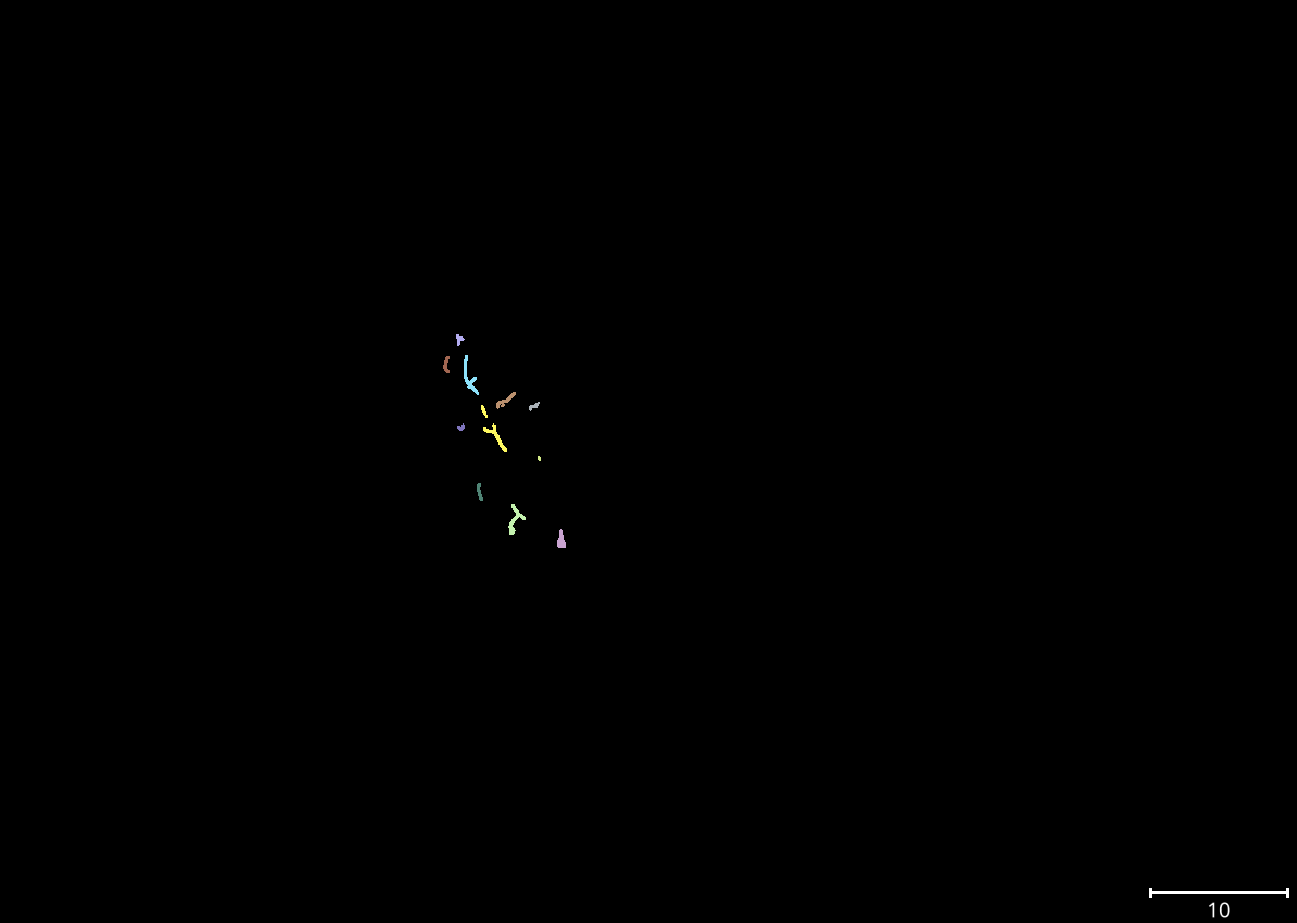

In [28]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)

In [30]:
viewer.close()

-------------
## SUMMARY

The above details how the golgi body object is inferred.  

### NEXT: INFER PEROXISOME

proceed to [07_infer_peroxisome.ipynb](./07_infer_peroxisome.ipynb)
